In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [402]:
df = pd.read_csv('all_updated_with_weather.csv')
for col in ['day of week', 'is_Weekday', 'hour']:
    df[col] = df[col].astype('object')
df = df.drop(['osname', 'avg_speed', 'day', 'month'], axis = 1) 
df = df[df['duration']<7200]

target_col = ['duration']
id_col = ['trj_id']

numerical_cols = ['avg_bearing', 'origin_avg_daily_rainfall', 'dest_avg_daily_rainfall',
       'origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist']

categorical_cols = ['day of week', 'is_Weekday', 'hour','time_group', 'origin_region', 'origin_subregion', 'dest_region', 
                    'dest_subregion']


#Scaling MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
def process_numerical_data(df, numerical_cols):
    sacaler = MinMaxScaler()
    df_numerical = sacaler.fit_transform(df[numerical_cols])
    return df_numerical

df_numerical = process_numerical_data(df, numerical_cols)
nums = pd.DataFrame(df_numerical, columns = ['avg_bearing', 'origin_avg_daily_rainfall ', 'dest_avg_daily_rainfall',
       'origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist'])

cats = df[categorical_cols]
# Create LabelEncoder object: le
le = LabelEncoder()

cols_toencode = ['time_group','origin_region', 'origin_subregion', 'dest_region', 'dest_subregion']
# Apply LabelEncoder to categorical columns
cats[cols_toencode] = cats[cols_toencode].apply(lambda x: le.fit_transform(x))
time_group_mappings = {index: label for index, label in 
                  enumerate(le.classes_)}


C:\Users\natalielam\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [403]:
df_features = np.hstack((nums, cats))
df_features = pd.DataFrame(df_features, columns = ['avg_bearing', 'origin_avg_daily_rainfall', 'dest_avg_daily_rainfall',
       'origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist', 'day of week', 'is_Weekday', 'hour', 'time_group',
                                                  'origin_region', 'origin_subregion', 'dest_region', 'dest_subregion'])

In [404]:
for col in numerical_cols:
    df_features[col] = df_features[col].astype('float')
for col in categorical_cols:
    df_features[col] = df_features[col].astype('int')

Train test split

In [405]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df[target_col], test_size=0.2, random_state=0)

Visualising feature importance using RandomForestRegressor

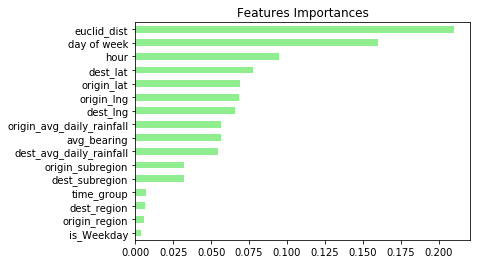

In [406]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train.values.ravel())

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

Visualizing feature importance using Lasso

{'avg_bearing': -21.84692272384512, 'origin_avg_daily_rainfall': 43.09171448808672, 'dest_avg_daily_rainfall': 72.20527689382959, 'origin_lat': -18.275018112239724, 'origin_lng': -0.0, 'dest_lat': 3.599834823648238, 'dest_lng': -6.911101927085738, 'euclid_dist': 864.05933153179, 'day of week': 51.72930298180775, 'is_Weekday': 116.57526207591944, 'hour': -0.2272316712083914, 'time_group': -13.58356687488562, 'origin_region': 2.775918097240416, 'origin_subregion': -0.27246263005202087, 'dest_region': 3.98163993166974, 'dest_subregion': -0.05314134952441216}


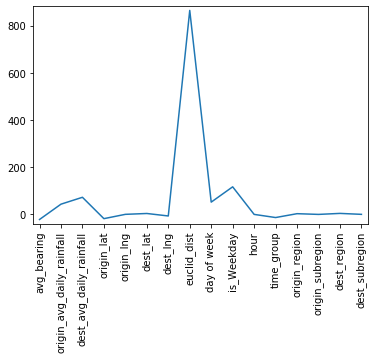

In [407]:
la = Lasso(alpha = 0.18)
la.fit(X_train, y_train)
print(dict(zip(X_train.columns,la.coef_)))

plt.plot(range(len(df_features.columns)), la.coef_)
plt.xticks(range(len(df_features.columns)), df_features.columns, rotation = 90)
plt.margins(0.02)
plt.show()

Seeing which were the top 11 columns chosen with RFE and different estimators

In [408]:
#ElasticNet
rfe_en = RFE(estimator = ElasticNet(), n_features_to_select = 11, verbose = 1)
rfe_en.fit(X_train, y_train.values.ravel())
en_mask = rfe_en.support_
sel_1 = df_features.loc[:,en_mask]
print('The 11 columns selected for ElasticNet are: {}'.format(sel_1.columns)) 
print('ElasticNet done..')

# RandomForestestRegressor Model
rfe_rf = RFE(estimator = RandomForestRegressor(), n_features_to_select = 11, verbose =1)
rfe_rf.fit(X_train, y_train.values.ravel())
rf_mask = rfe_rf.support_
sel_2 = df_features.loc[:, rf_mask] #top 10 columns for RF
print('The 11 columns selected for RF are: {}'.format(sel_2.columns))
print('RandomForestRegressor done..')

#GradientBoostingRegressor Model
rfe_gb = RFE(estimator = GradientBoostingRegressor(), n_features_to_select = 11, verbose = 1)
rfe_gb.fit(X_train, y_train.values.ravel())
gb_mask = rfe_gb.support_
sel_3 = df_features.loc[:, gb_mask] #top 10 columns for GB
print('The 11 columns selected for GB are: {}'.format(sel_3.columns))
print('GradientBoostingRegressor done')

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
The 11 columns selected for ElasticNet are: Index(['origin_avg_daily_rainfall', 'dest_avg_daily_rainfall', 'origin_lat',
       'dest_lng', 'euclid_dist', 'day of week', 'is_Weekday', 'hour',
       'time_group', 'origin_region', 'dest_region'],
      dtype='object')
ElasticNet done..
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
The 11 columns selected for RF are: Index(['avg_bearing', 'origin_avg_daily_rainfall', 'dest_avg_daily_rainfall',
       'origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist',
       'day of week', 'hour', 'dest_subregion'],
      dtype='object')
RandomForestRegressor done..
Fitting estimator with 16 features.
Fitting estimator with 15 feat

From the above, we have creating two subset columns - first_reduced and another_reduced, these are the top 11 columns

In [387]:
first_reduced = ['origin_avg_daily_rainfall', 'dest_avg_daily_rainfall',
       'origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist',
       'day of week', 'hour', 'dest_subregion', 'avg_bearing']
train_x, test_x, train_y, test_y = train_test_split(df_features[first_reduced], df[target_col], test_size=0.2, 
                                                    random_state=0)

another_reduced = ['origin_avg_daily_rainfall', 'dest_avg_daily_rainfall', 'origin_lat',
       'origin_lng', 'dest_lat', 'dest_lng', 'euclid_dist', 'day of week', 'hour', 'is_Weekday', 'time_group']
tra_x, te_x, tra_y, te_y = train_test_split(df_features[another_reduced], df[target_col], random_state =0, test_size = 0.2)

Compare how the original/first_reduced/another_reduced performed for various models

In [391]:
# VotingRegressor Model
reg1 = GradientBoostingRegressor(random_state=0, n_estimators=50)
reg2 = RandomForestRegressor(random_state=0, n_estimators=50)
reg3 = LinearRegression()
reg4 = ElasticNet(random_state=0)

old_reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('en', reg4)])
first_reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('en', reg4)])
another_reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('en', reg4)])

old_reg.fit(X_train, y_train.values.ravel())
first_reg.fit(train_x, train_y.values.ravel())
another_reg.fit(tra_x, tra_y.values.ravel())

old_rmse = mean_squared_error(y_test, old_reg.predict(X_test))**(1/2)
first_rmse = mean_squared_error(test_y, first_reg.predict(test_x))**(1/2)
another_rmse = mean_squared_error(te_y, another_reg.predict(te_x))**(1/2)

print('VotingRegressor:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(old_rmse, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(first_rmse, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(another_rmse, len(df_features[another_reduced].columns)))


VotingRegressor:

The RMSE of the old test set is: 253.75383379948366 using 16 features.
The RMSE of the first reduced test set is: 254.79338174024528 using 11 features.
The RMSE of the another reduced test set is: 253.5019852466415 using 11 features.


In [392]:
#RandomForestRegressor Model
dog = RandomForestRegressor(random_state=0)
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = RandomForestRegressor(random_state = 0)
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))


mouse = RandomForestRegressor(random_state = 0)
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('RanfomForestRegressor:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))


RanfomForestRegressor:

The RMSE of the old test set is: 222.1515709153164 using 16 features.
The RMSE of the first reduced test set is: 222.30810714210838 using 11 features.
The RMSE of the another reduced test set is: 222.27802682021743 using 11 features.


In [393]:
#LinearRegression
dog = LinearRegression()
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = LinearRegression()
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

mouse = LinearRegression()
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('LinearRegression:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))


LinearRegression:

The RMSE of the old test set is: 289.4048087249992 using 16 features.
The RMSE of the first reduced test set is: 292.64890551681225 using 11 features.
The RMSE of the another reduced test set is: 289.251490181952 using 11 features.


In [396]:
#XGBRegressor
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25,30],
    'max_depth': range(2,12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = GridSearchCV(estimator = gbm, param_grid= gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)

randomized_mse.fit(df_features, df[target_col])
print("Best parameters found for original: ", randomized_mse.best_params_)
print("The RMSE of the original test set is: {}".format(np.sqrt(np.abs(randomized_mse.best_score_))))

# Fit randomized_mse to the data
randomized_mse.fit(df_features[first_reduced], df[target_col])
# Print the best parameters and lowest RMSE
print("Best parameters found for first reduced: ", randomized_mse.best_params_)
print("The RMSE of the first reduced test set is: {}".format(np.sqrt(np.abs(randomized_mse.best_score_))))


randomized_mse.fit(df_features[another_reduced], df[target_col])
print("Best parameters found for another reduced: ", randomized_mse.best_params_)
print("The RMSE of the another reduced test set is: {} ".format(np.sqrt(np.abs(randomized_mse.best_score_))))


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   27.7s finished


Best parameters found for original:  {'max_depth': 8, 'n_estimators': 30}
The RMSE of the original test set is: 238.56882965291288
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   27.9s finished


Best parameters found for first reduced:  {'max_depth': 7, 'n_estimators': 30}
The RMSE of the first reduced test set is: 238.07302462639126
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   24.3s finished


Best parameters found for another reduced:  {'max_depth': 7, 'n_estimators': 30}
The RMSE of the another reduced test set is: 238.107141083867 


In [397]:
#ElasticNet
dog = ElasticNet(random_state = 0)
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = ElasticNet(random_state = 0)
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

mouse = ElasticNet(random_state = 0)
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('ElasticNet:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))

ElasticNet:

The RMSE of the old test set is: 310.71413664938365 using 16 features.
The RMSE of the first reduced test set is: 312.81776385647254 using 11 features.
The RMSE of the another reduced test set is: 310.9908909622862 using 11 features.


In [398]:
#GradientBoostingRegressor

dog = GradientBoostingRegressor(random_state=0, n_estimators=20)
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = GradientBoostingRegressor(random_state=0, n_estimators=20)
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

mouse = GradientBoostingRegressor(random_state=0, n_estimators=20)
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('GradientBoostingRegressor:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))

GradientBoostingRegressor:

The RMSE of the old test set is: 272.95014885817005 using 16 features.
The RMSE of the first reduced test set is: 272.94916647741746 using 11 features.
The RMSE of the another reduced test set is: 272.9491664774174 using 11 features.


In [399]:
#AdaBoostRegressor
dt = DecisionTreeRegressor(max_depth= 7, random_state=0)
#ada = AdaBoostRegressor(base_estimator= dt, n_estimators= 180, random_state=0)

dog = AdaBoostRegressor(base_estimator= dt, n_estimators= 180, random_state=0)
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = AdaBoostRegressor(base_estimator= dt, n_estimators= 180, random_state=0)
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

mouse = AdaBoostRegressor(base_estimator= dt, n_estimators= 180, random_state=0)
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('AdaBoostRegressor:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))

AdaBoostRegressor:

The RMSE of the old test set is: 355.4082349953589 using 16 features.
The RMSE of the first reduced test set is: 346.82215869410857 using 11 features.
The RMSE of the another reduced test set is: 334.7760347210581 using 11 features.


In [400]:
#MLPRegressor
dog = MLPRegressor(max_iter = 300, random_state = 0)
dog.fit(train_x, train_y.values.ravel())
rmse_dog = np.sqrt(mean_squared_error(test_y, dog.predict(test_x)))

cat = MLPRegressor(max_iter = 300, random_state = 0)
cat.fit(X_train, y_train.values.ravel())
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

mouse = MLPRegressor(max_iter = 300, random_state = 0)
mouse.fit(tra_x, tra_y.values.ravel())
rmse_mouse = np.sqrt(mean_squared_error(te_y, mouse.predict(te_x)))

print('MLPRegressor:\n')
print('The RMSE of the old test set is: {} using {} features.'.format(rmse_cat, 16))
print('The RMSE of the first reduced test set is: {} using {} features.'.format(rmse_dog, len(df_features[first_reduced].columns)))
print('The RMSE of the another reduced test set is: {} using {} features.'.format(rmse_mouse, len(df_features[another_reduced].columns)))

C:\Users\natalielam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\natalielam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor:

The RMSE of the old test set is: 279.97170018605885 using 16 features.
The RMSE of the first reduced test set is: 283.3317846544979 using 11 features.
The RMSE of the another reduced test set is: 280.8945792551073 using 11 features.


C:\Users\natalielam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
